# Modeling Disability-Adjusted Life Years for Policy and Decision

Analysis- A Tutorial

John Graves  
Jinyi Zhu  
Grace Ratcliff  
Hannah Peterson  
Marie Martin  
Shawn Garbett  
Ashley A. Leech  
August 22, 2024

This study outlines methods for modeling disability-adjusted life years (DALYs) in common decision modeling frameworks. Recognizing the wide spectrum of experience and programming comfort level among practitioners, we outline two approaches for modeling DALYs it its constitutent parts, Years of Life Lost to Disease (YLL) and Years of Life Lived with Disability (YLD). Our beginner approach draws on the Markov trace, while the intermediate approach facilitates more efficient estimation by incorporating non-Markovian tracking elements into the transition probability matrix. Drawing on an existing disease progression discrete time Markov cohort model, we demonstrate equivalence of DALY estimates and cost-effectiveness analysis results across our methods and show that other commonly used “shortcuts” for estimating DALYs will not, in general, yield accurate estimates of DALY levels nor ICERs in a modeled population.

# 1. Introduction

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: Matrix

Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Attaching package: 'expm'

The following object is masked from 'package:Matrix':

    expm


Attaching package: 'kableExtra'

The following object is masked from 'package:dplyr':

    group_rows

here() starts at /Users/johngraves/Dropbox/Projects/dalys


Attaching package: 'Hmisc'

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units


Attaching package: 'janitor'

The following objects are masked from 'package:stats':

    chisq.test, fisher.test


Attaching package: 'flextable'

The following objects are masked from 'package:kableExtra':

    as_image, footnote

The following object is masked from 'package:purrr':

    compose

> **Tip**
>
> Support for this work is graciously acknowledged from the [Data to Policy](https://www.d4hdataimpact.org/data-to-policy) program administered by Vital Strategies and the CDC Foundation with funding from the Bloomberg Philanthropies Data for Health Initiative

Disability-adjusted life years (DALYs) measure disease burden in a population. Conceptualized in the Global Burden of Disease (GBD) study ([C. J. Murray and Lopez 1997](#ref-Murray1997)), DALYs quantify the total sum of years of life lost due to disability attributable to a disease (YLD), plus years of life lost to premature mortality from the disease (YLL; i.e., DALY = YLD + YLL).

In addition to their role in describing levels and trends in disease burdens worldwide, DALYs are a primary health outcome in evaluations of health interventions in low- and middle-income countries (LMICs). In these settings, resource allocation decisions are guided by modeled assessments of the incremental costs per DALY averted under alternative (often competing) strategies to improve population health.[1]

Despite the prominent role of DALYs in global health policy, scant methodological guidance is available for adapting and/or structuring decision analytic models for DALY outcomes. This methodological gap has its roots in health economics education, where textbooks and training exercises focus almost exclusively on Quality-Adjusted Life Year (QALY) outcomes—the primary health outcome used for health technology assessments and policy decision-making in high-income countries. DALYs differ from QALYs in important and model-relevant respects, including the use of reference life tables to calculate YLLs and standardized disability weights to calculate YLDs.[2] To the extent DALY-specific modeling considerations are taught, they are often considered in isolation and without a firm methodological grounding in how one might structure a model to measure DALY outcomes.

As a consequence, and in practice, health economic applications often resort to shortcuts and other “hacks” for calculating DALYs. For example, practitioners may simply estimate a “QALY-like” DALY that is based on a diseased state occupancy payoff of one minus the disability weight. Other approaches define a diseased-state payoff using the disability weight as an estimate of YLDs and accumulate person-years in an absorbing death state (due to disease) as an estimate of YLLs. As this study will show, these shortcuts do not provide an accurate representation of DALY levels in a population.

This study outlines methods for direct incorporation of DALY outcomes in common decision modeling environments. Our primary focus is on discrete-time Markov cohort models—however, our framework extends directly to microsimulation and is also easily adapted for continuous time discrete event simulation (DES) models.

To maintain consistency within the literature, we build on an existing didactic disease progression model ([Alarid-Escudero et al. 2023](#ref-alarid2023introductory)). The underlying discrete-time Markov cohort model is time homogeneous—that is, transition probabilities do not vary as a function of age/time in the model. However, our methods and code are developed to accommodate time-inhomogeneous models. Finally, recognizing the wide spectrum of experience and programming comfort level among practitioners, we offer two approaches for modeling DALYs (beginner, intermediate) and provide replication materials for implementing our approaches in R and Microsoft Excel.

# 2. Background

This section provides background information sufficient for conceptual understanding of DALYs and how to estimate them in a decision-analytic model; it is not intended as a comprehensive treatment of the subject. For extensive discussion of the history, assumptions and controversies around DALYs, see Arnesen and Nord ([1999](#ref-arnesen1999)), Mathers ([2020](#ref-mathers2020)) and Parks ([2014](#ref-parks2014)).

## 2.1 Years of Life Lived with Disability (YLD)

To quantify YLDs, conditions are assigned disability weights ($D$) ranging from zero to one, with zero representing the absence of the condition and one representing the highest burden a condition can inflict. Disability weights are elicited, in part, from expert panels. Weights are standardized across geographies and are routinely updated and published on the GBD website ([WHO 2020](#ref-who2020methods); [Disease Collaborative Network 2024](#ref-global_burden_of_disease_collaborative_network_global_2024)).

For a given condition $c$, YLDs are defined as the condition’s disability weight multiplied by the average number of years a person lives with the disease ($L_c$):

<span id="eq-yld1">$$
YLD(c) = D_c \cdot L_c
 \qquad(1)$$</span>

## 2.2 Years of Life Lost to Disease (YLL)

YLLs are determined by a loss function, which is typically defined as the number of years lost to premature mortality. This value is often taken from a life table that provides information on remaining life expectancy at age of premature death, $a$,

<span id="eq-yll1">$$
YLL(a)= Ex(a)
 \qquad(2)$$</span>

For example, if an individual dies of a disease at age 60, and the remaining life expectancy for a 60 year-old is 30 years, then the YLL value for that individual would take a value of 30.

Choices over the specific value of remaining life expectancy will depend on the context and research question at hand ([Anand and Reddy 2019](#ref-anand2019)). Historically, the GBD has utilized an *exogenous*, external reference life table based on the maximum potential life span among humans ([WHO 2020](#ref-who2020methods); [Disease Collaborative Network 2021](#ref-globalburdenofdiseasecollaborativenetwork2021)). More recent GBD estimates draw on reference life tables based on the lowest observed age-specific mortality rates among geographies with populations over 5 million in 2016 ([Disease Collaborative Network 2021](#ref-globalburdenofdiseasecollaborativenetwork2021)).

## 2.3 Disability-Adjusted Life Years

DALYs are simply the sum of these two components:

<span id="eq-daly">$$
DALY(c,a) = YLD(c) + YLL(a)
 \qquad(3)$$</span>

## 2.4 Discounting

In the original GBD study, additional age-weighting and time discounting practices were applied to DALY calculations ([C. J. Murray and Lopez 1997](#ref-Murray1997)). These methods respectively weighted the burden of illness more during adulthood than early childhood and old age, and valued present health over future years of illness by discounting YLD and YLL measures by 3% per year. From 2010 onwards, both practices were discontinued to make the DALY a more descriptive measure ([WHO 2020](#ref-who2020methods)).

While the GBD no longer uses age and time discounting, the World Health Organization’s Choosing Interventions that are Cost-Effective (WHO-CHOICE) program recommends consideration of time discounting of health outcomes ([C. J. L. Murray et al. 2020](#ref-murray2020); [Bertram et al. 2021](#ref-bertram2021)). This creates a methodological tension between the GBD approach to quantifying disease burden, and WHO approaches for cost-effectiveness analysis and health technology assessments.

To be comprehensive, we adopt the WHO-CHOICE recommendation and include discounting in our DALY modeling approach—though practitioners who do not wish to discount can simply set the discount rate to zero. One minor point of departure from standard methods is that we maintain the continuous-time discounting used in the original GBD DALY equations—which differs slightly from the more common use of discrete time discounting in Markov cohort models. We do so to allow for consistent discounting of YLDs and YLLs, since YLL values draw on continuous time discounting to calculate a present value of remaining life expectancy at the time of premature death.

For an annual discount rate $r$, for condition $c$, and at age $a$, the equation for YLDs is,

<span id="eq-yld">$$
YLD(c) = D_c  \left ( \frac{1}{r}\left(1-e^{-r(L_c) }\right) \right ).
 \qquad(4)$$</span>

Similarly, YLLs are calculated as,

<span id="eq-yll">$$
YLL(a)= \frac{1}{r}\left(1-e^{-r Ex(a)}\right).
 \qquad(5)$$</span>

It is important to note that the discounting shown in <a href="#eq-yld" class="quarto-xref">Equation 4</a> and <a href="#eq-yll" class="quarto-xref">Equation 5</a> yields the present value of YLD and YLL outcomes at a single point in time when the duration of disease ($L_c$) and time of death from disease ($a$) are known. For a decision model where not all cohort members start ill, that point in time very likely occurs at some point after the baseline period—and different illness durations and death times will, of course, occur across individuals in a modeled cohort. As such, we must discount YLL and YLD outcomes further, to time point $t=0$ to align outcomes to the same starting point. This additional discounting step will become apparent in <a href="#sec-outcomes" class="quarto-xref">Section 4.2</a> below.

# 3. Overview of Decision Problem

We build on an existing progressive disease model in which healthy individuals develop a disease with two health states (“Sick” and “Sicker”; Alarid-Escudero et al. ([2023](#ref-alarid2023introductory))). Individuals can also transition to an absorbing death state due to causes unrelated to the disease (i.e., “background” mortality), or due to disease-specific causes.

We consider outcomes under four strategies:

-   A **Standard of Care** strategy based on the baseline model parameters.
-   **Strategy A**, which improves the quality of life among individuals with the disease, but does not affect disease progression.
-   **Strategy B**, which reduces the rate of progression from Sick to Sicker by 40%.
-   **Composite Strategy AB**, which implements strategies A and B independently and concurrently.

A state transition diagram is shown in <a href="#fig-model1" class="quarto-xref">Figure 1</a>. In the figure, nodes are health states and edges depict transitions among them. Edge labels are defined in terms of transition intensities (rates). Other key model parameters are summarized in <a href="#tbl-params" class="quarto-xref">Table 1</a>.

As depicted in <a href="#fig-model1" class="quarto-xref">Figure 1</a>, the underlying Markov model is time homogeneous—that is, transition rates do not vary as a function of age/time. This is merely a simplification that builds on an existing time-homogeneous model constructed for didactic purposes ([Alarid-Escudero et al. 2023](#ref-alarid2023introductory)). We do, however, index all formulas and other model-relevant objects with the subscript $t$ to allow for time-inhomogenous models. Our replication code is also written to accommodate time-inhomogeneous models.

<figure id="fig-model1">

<figcaption>Figure 1: State transition diagram for progressive disease model</figcaption>
</figure>

[1] The adoption of DALYs over other common health outcomes in health economics (e.g., quality-adjusted life years, or QALYs) stems from several practical and theoretical considerations. See Feng et al. ([2020](#ref-Feng2020)) and Wilkinson et al. ([2016](#ref-Wilkinson2016)) for further discussion.

[2] In contrast, QALYs are calculated based on utility weights derived from general and patient surveys. See Feng et al. ([2020](#ref-Feng2020)) and Wilkinson et al. ([2016](#ref-Wilkinson2016)) for further discussion.

In [ ]:
params_ <- list(
    # Treatment Strategies
    v_tx_names = c("SoC","A","B","AB"),      # treatment names
    n_tx = 4, # number of treatment strategies
    
    cycle_correction = "half-cycle",
    
    v_tr_names = c("H","S1","S2"), # transient health states
    v_ab_names = c("DOC","DS"), # absorbing health states
    n_states = 5, # total number of health states
    
    horizon = 500, # model time horizon (in years)  
    r_v_disc_h  = 0.03,     # annual discount rate for health outcomes
    r_v_disc_c = 0.03,     # annual discount rate for cost outcomes
    Delta_t = 1,      # time step (1 = yearly, 1/12 = monthly, etc.)
    age0 = 25,         # age at baseline
    v_s0T = c(1,0,0,0,0), # initial state occupancy  

    r_HS1 = 0.15,   # disease onset rate
    r_S1H = 0.5,    # recovery rate
    r_S1S2 = 0.105,   # disease progression rate
    r_HD = .002,  # TK .002 # background mortality rate
    
    hr_S1 = 3.0,     # hazard rate of disease-related death from S1 state
    hr_S2 = 10.0,    # hazard rate of disease-related death from S1 state

    dw_S1 = 0.25,      # Sick disability weight
    dw_S2 = 0.5,       # Sicker disability weight
    
    c_H = 2000,   # annual cost of healthy
    c_S1 = 4000,  # annual cost of S1
    c_S2 = 15000, # annual cost of S2
    c_D = 0, # annual cost of death

    c_trtA = 12000, # cost of treatment A

    dw_trtA = 0.05,    # Disability weight for sick under treatment A
    
    c_trtB = 13000, # cost of treatment B
    hr_S1S2_trtB = 0.6, # reduction in rate of disease progression 

    df_ExR =  
      # Global Burden of Disease Collaborative Network. Global Burden of Disease Study 2019 
      # (GBD 2019) Reference Life Table. Institute for Health Metrics and Evaluation (IHME); 
      # 2021. doi:10.6069/1D4Y-YQ37. Accessed November 30, 2023.
          tibble::tribble(
              ~Age, ~Life.Expectancy,
              0L,       88.8718951,
              1L,      88.00051053,
              5L,      84.03008056,
              10L,      79.04633476,
              15L,       74.0665492,
              20L,      69.10756792,
              25L,      64.14930031,
              30L,       59.1962771,
              35L,      54.25261364,
              40L,      49.31739311,
              45L,      44.43332057,
              50L,      39.63473787,
              55L,      34.91488095,
              60L,      30.25343822,
              65L,      25.68089534,
              70L,      21.28820012,
              75L,      17.10351469,
              80L,      13.23872477,
              85L,      9.990181244,
              90L,      7.617724915,
              95L,      5.922359078
          ) 
)

params <- 
    with(params_,{
        modifyList(params_,list(
            v_names_states = c(v_tr_names, v_ab_names), # health state names
            omega = horizon/Delta_t,  # Total number of cycles
            r_v_disc_h_Delta_t = r_v_disc_h * Delta_t,  # Cycle discount rate: health outcomes
            r_v_disc_c_Delta_t = r_v_disc_c * Delta_t,  # Cycle discount rate: cost outcomes
            ages = (0:(horizon/Delta_t))*Delta_t + age0,  # Age in each cycle
             # Approximation function for reference life table life expectancies:
            f_ExR = function(x) pmax(0,unname(Hmisc::approxExtrap(df_ExR$Age, df_ExR$Life.Expectancy,xout = x)$y))
        ))
    })

params$ages_trace <- params$ages
params$ages <- params$ages[-length(params$ages)] 

# Discounting vectors 

v_disc_h =  # Continuous time discounting
  exp(-params$r_v_disc_h_Delta_t  * 0:(params$omega))

v_disc_c = 
  exp(-params$r_v_disc_c_Delta_t  * 0:(params$omega))

In [ ]:
params_lut <- 
  list(
    "v_tx_names" = "Treatment strategies (vector)",
    "n_tx" = "Number of treatment strategies",
    "cycle_correction" = "Cycle correction method",
    "v_tr_names" = "Transient health state names (vector)",
    "v_ab_names" = "Absorbing health state names (vector)",
    "n_states" = "Total number of health states",
    "horizon" = "Model time horizon (years)",
    "r_v_disc_h" = "Annual discount rate for health outcomes",
    "r_v_disc_c" = "Annual discount rate for cost outcomes",
    "Delta_t" = "Time step (cycle length; 1=annual, 1/12=monthly, etc.)", 
    "age0" = "Age at baseline",
    "r_HS1" = "Transition rate: healthy to sick",
    "r_S1H" = "Transition rate: sick to healthy",
    "r_S1S2" = "Transition rate: sick to sicker",
    "r_HD" = "Transition rate: Disease-free background mortality",
    "hr_S1" = "Hazard ratio: mortality from sick state",
    "hr_S2" = "Hazard ratio: mortality from sicker state", 
    "dw_S1" = "Disability weight: sick [S1]",
    "dw_S2" = "Disability weight: sicker [S2]",
    "c_H" = "Cycle occupancy cost: healthy [H]",
    "c_S1" = "Cycle occupancy cost: sick [S1]",
    "c_S2" = "Cycle occupancy cost: sicker [S2]",
    "c_D" = "Cycle occupancy cost: death [D]", 
    "c_trtA" = "Cycle occupancy cost: treatment A [S1,S2]",
    "dw_trtA" = "Disbility weight: treatment A [S1]",
    "c_trtB" = "Cycle occupancy cost: treatment B [S1,S2]",
    "hr_S1S2_trtB"= "Hazard Ratio: S1 to S2 disease progression under treatment B"
  )
str_params_ <- params_ %>% map_dbl(~(length(.x)))

vec_params <- str_params_[str_params_<5 & str_params_>1] %>% names()
vec_params <- vec_params[which(vec_params!="df_ExR")]
vec_params_ <- 
  params_[vec_params] %>% 
  map(~(paste0(.,collapse=","))) %>% 
  {glue::glue("({.})'")} 
names(vec_params_) = vec_params

cost_params <- grep("^c_",names(str_params_),value=TRUE)
cost_params_ <- params_[cost_params] %>% 
  map(~(paste0(format(.,big.mark=','),collapse=","))) %>% 
  {glue::glue("${.}")} 
names(cost_params_) = cost_params

sc_params <- str_params_[str_params_==1 ] %>% names()
sc_params <- sc_params[-grep("^c_",sc_params)]

labels_params <- intersect(names(params),c(vec_params,sc_params,cost_params))

ft <- tibble(parameter = c(sc_params,cost_params,vec_params),value = unname(c(params_[sc_params],cost_params_, vec_params_))) %>% 
  mutate(value = paste0(value)) %>% 
  mutate(label = paste0(factor(parameter,levels = labels_params, labels = params_lut[labels_params]))) %>% 
  mutate(parameter = factor(parameter,levels = labels_params)) %>% 
  arrange(parameter) %>% 
  rename("Parameter Name" = parameter, "Value" = value, "Description" = label) %>% 
  flextable(cwidth = 2) %>% 
  add_footer_lines("Source: Alarid-Escudero et al. (2023) and authors' assumptions.") 

ft

# 4. Methods

## 4.1 Transition Matrices

With the model parameterized, we next define the matrices that govern transitions. The state transition diagram represented in <a href="#fig-model1" class="quarto-xref">Figure 1</a> is not yet well-suited to calculate DALY outcomes, however. A primary reason is that transitions to the absorbing death state capture transitions due to all causes of death. To calculate YLLs, we must separately track the timing and number of deaths *due to disease*.

To accommodate this need, we develop two approaches for modeling DALY outcomes. We categorize each based on the level of experience and skill required:

1.  **Approach 1 (Beginner): Separate Death State**: Re-define the health states to include a separate cause-specific death state as depicted in <a href="#fig-modelDS" class="quarto-xref">Figure 2</a>.[1] We then construct a Markov trace tracking state occupancy in each cycle and use changes in the number of cause-specific deaths across cycles to calculate YLLs.

2.  **Approach 2 (Intermediate): Non-Markovian Trackers**: Augment the transition matrices to include a non-Markovian transition state for cause-specific deaths. This approach allows for efficient calculation of YLD, YLL and DALY outcomes (often useful for microsimulation or probabilistic sensitivity analyses) because it sidesteps the need to derive a Markov trace.

Each approach facilitates the design and execution of a decision-analytic model that correctly calculates YLD, YLL, and DALY outcomes—as well as other common outcomes such as life-years (LYs), QALYs and costs. In practice, Approaches (1) and (2) will produce identical results. We show in <a href="#sec-results" class="quarto-xref">Section 5</a> that other shortcut-based approaches previously used in the literature—such as modeling a QALY-like DALY and/or accumulating time in the absorbing death state—will not in general yield similar results.

### 4.1.1 Beginner Approach (1): Cause-Specific Death State

Under this approach, we separate deaths from disease vs. other causes by defining a separate health state for cause-specific mortality; <a href="#fig-modelDS" class="quarto-xref">Figure 2</a> shows an updated state transition diagram.

<figure id="fig-modelDS">

<figcaption>Figure 2: State transition diagram for progressive disease model with separate cause-specific death state</figcaption>
</figure>

Transitions among health states are defined in terms of continuous rates (“intensities”) and are captured within an intensity matrix $\mathbf{Q}_t$,

<figure>
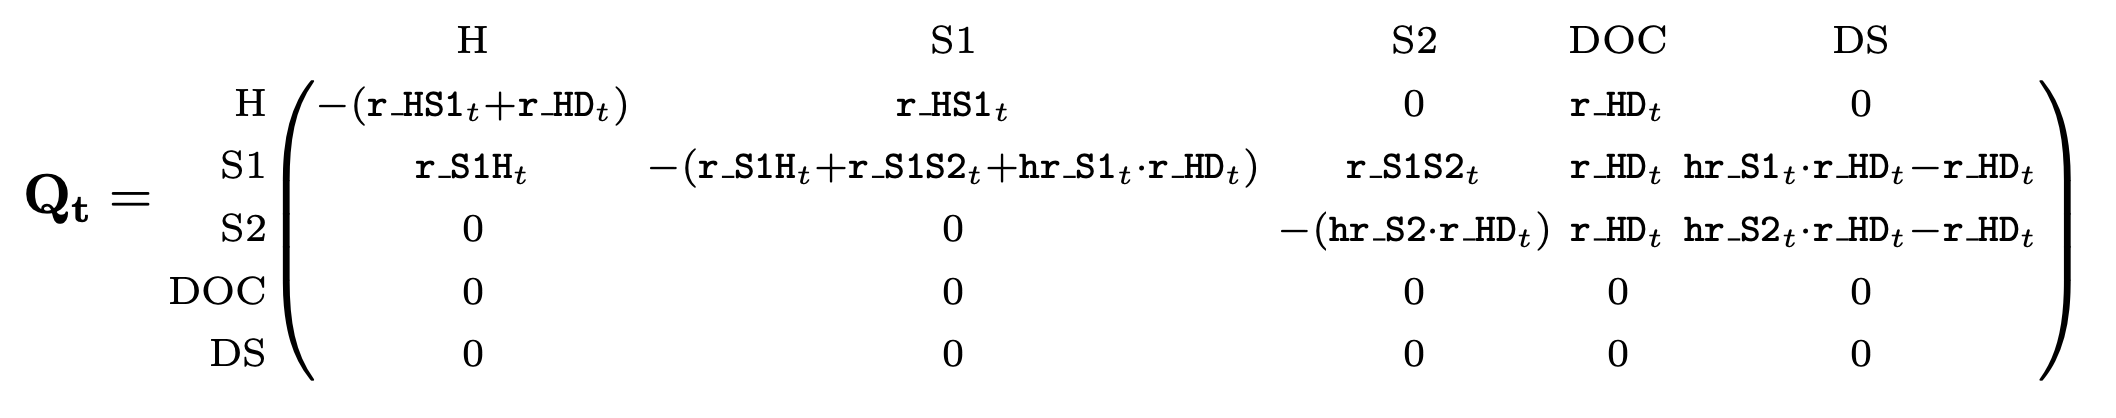
<figcaption aria-hidden="true">Transition Intensity Matrix for Approach 1</figcaption>
</figure>

Cell values in row $i$, column $j$ of $\mathbf{Q}_t$ capture the (continuous time) transition rate from health state $i$ to health state $j$. $\mathbf{Q}_t$ has diagonal elements defined as the negative sum of the off-diagonal row values (i.e., the row sums of $\mathbf{Q}_t$ are zero). This ensures that the Markov model is “closed”—that is, the total cohort size neither grows or shrinks over time.

We next embed the transition intensity matrix into a discrete time transition probability matrix by taking the matrix exponential of $\mathbf{Q}_t$ for a defined cycle length (“time step”) $\Delta t$:[2]

<span id="eq-embed">$$
\mathbf{P}_t = e^{\mathbf{Q}_t\Delta t}
 \qquad(6)$$</span>

Embedding the Sick-Sicker model results in a transition probability matrix $\mathbf{P}_t$ with the following probabilities defined:

<figure>
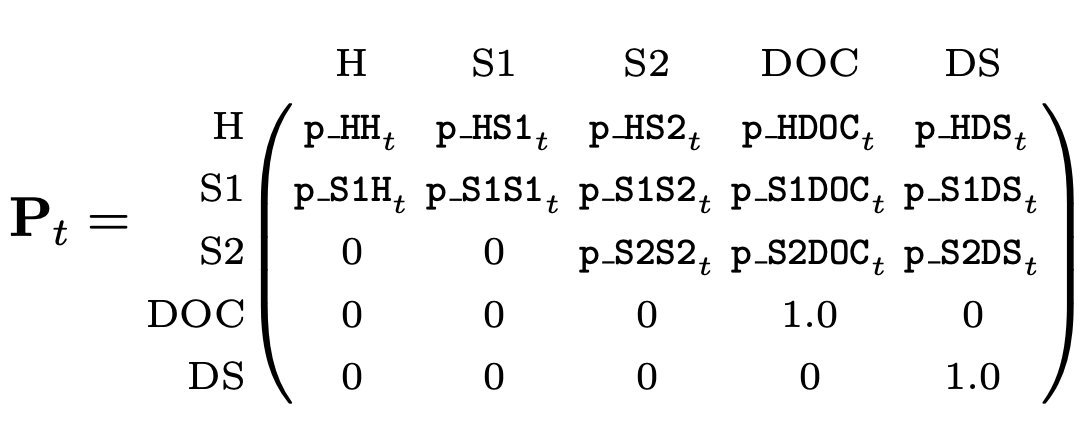
<figcaption aria-hidden="true">Transition Probability Matrix for Approach 1</figcaption>
</figure>

Embedding the transition probability matrix using <a href="#eq-embed" class="quarto-xref">Equation 6</a> ensures that the resulting transition probabilities capture the underlying continuous time disease process. In particular, $\mathbf{P}$ captures the possibility of multiple transitions within a single cycle.[3]

### 4.1.2 Intermediate Approach (2): Non-Markovian Tracking States

This method maintains the overall structure as depicted in the original <a href="#fig-model1" class="quarto-xref">Figure 1</a>, but augments the transition probability matrix with non-Markovian components to facilitate accounting of disease-related deaths.[4] Approach 2 offers a more generalized method that allows practitioners to accurately account for costs and/or health payoffs (such as YLLs) that are defined by *transitions* among health states, rather than occupancy in a health state. DALY outcomes can also be calculated directly, without the need to derive a vector of disease-related death transitions from the Markov trace (as required for Approach 1).

<a href="#fig-transition" class="quarto-xref">Figure 3</a> shows a state transition diagram with the tracking state added. The tracking state (shown as red nodes) simply records transitions as cohort members move from either diseased state to the absorbing death state due to causes related to the disease.

<figure id="fig-transition">

<figcaption>Figure 3: State Transition Diagram with Transition State (Red)</figcaption>
</figure>

In general, tracking states can either count the total number of transitions that have occurred up to a given cycle (i.e., an “accumulator” state), or can track the total number of new transitions that occur within a single cycle (i.e., a “transition” state).[5] To calculate YLL outcomes we will add a transition state that records the total number of new disease-related deaths in each cycle.

To implement Approach 2, we add a transition state row and column to the transition intensity matrix. This transition state, called $\texttt{trDS}$, is included in the augmented intensity matrix $\mathbf{Q}_t$ below:

<figure>
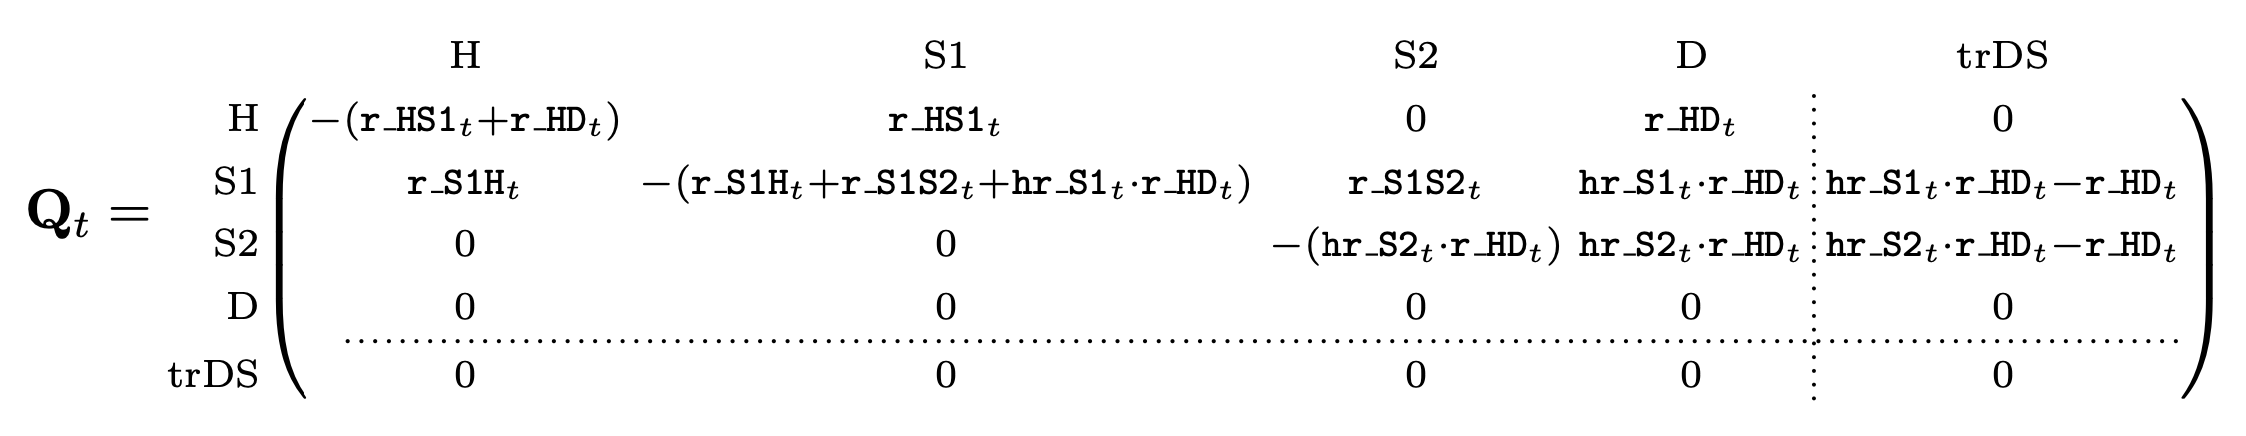
<figcaption aria-hidden="true">Transition intensity matrix with transition state added</figcaption>
</figure>

Two aspects of $\mathbf{Q}_t$ are worth highlighting. First, $\mathbf{Q}_t$ is divided into a Markovian submatrix and the non-Markovian tracking row and column. This division is made apparent using dotted vertical and horizontal lines. Critically, the Markovian submatrix remains closed—that is, the diagonal elements remain unchanged so that the row sums of the submatrix remain zero, even after the addition of the tracking column along the “edges” of $\mathbf{Q}_t$. This ensures that the Markovian submatrix can be used to calculate state occupancy for a closed cohort that neither gains nor loses cohort members over time.

Second, two transition intensities—from the S1 (Sick) and S2 (Sicker) states to Death—appear in the tracking column. This ensures that $\texttt{trDS}$ will track all relevant transitions to death due to the disease. Because we are operating on the rate scale, we can net out non-disease-related deaths as captured by the background mortality rate among healthy individuals (i.e., $\texttt{r\_HD}$). Other approaches might draw on cause-deleted life tables to incorporate death transition rates that net out deaths from the disease itself.[6]

As above, we obtain the transition probability matrix by embedding $\mathbf{Q}_t$ into the discrete time step (<a href="#eq-embed" class="quarto-xref">Equation 6</a>). However, the resulting transition probability matrix treats $\texttt{trDS}$ as an absorbing state (i.e., individuals are retained in $\texttt{trDS}$ with probability one). Using the terminology introduced above, this absorbing state could serve as an **accumulator** state that (in the constructed Markov trace) records the total number of people who have died from the disease up to any given cycle. This may be a decision-relevant health outcome to consider on its own; indeed, so long as the Markovian submatrix remains closed, there is no limit to the number of accumulator and/or transition states one might add along the “edges” of a transition matrix.[7]

To change $\texttt{trDS}$ to a **transition** state, we simply replace the absorbing probability of one in the cell $[\texttt{trDS},\texttt{trDS}]$ with a zero. This cell-level change is highlighted in grey in the bottom right cell of $\mathbf{P}$ below:

<figure>
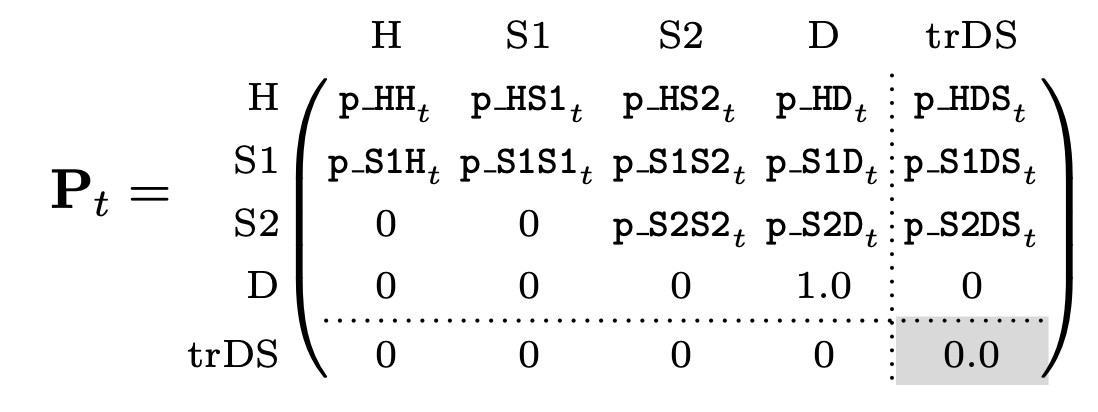
<figcaption aria-hidden="true">Transition Probability Matrix for Approach 2</figcaption>
</figure>

[1] In this example, disease-specific death rates are governed by a hazard ratio applied to the background mortality rate. Because we are operating on the rate scale, we can separate out disease-related deaths from other-cause mortality by simply taking a difference in the rates. Other applications for prevalent conditions with high death rates, however, may require us to construct a cause-deleted life table to obtain background mortality rates that net out deaths from the modeled disease.

[2] In Markov theory, $\mathbf{P}$ is called the “discrete skeleton” of the continuous model ([Iosifescu 1980](#ref-iosifescu1980)). The conversion formula used to calculate $\mathbf{P}$ is the matrix analogue to the standard rate-to-probability formula commonly taught in health economics textbooks, i.e., $p = 1 - e^{r\Delta t}$, where $r$ is the rate and $\Delta t$ is the time step (i.e., “cycle length”).

[3] For example, in the continuous time rate matrix $\mathbf{Q}_t$ above, there is a zero-valued rate defined for progressions from Healthy (H) to Disease-related death (DS), since individuals must first become ill before they can die from disease-related causes. However, after embedding, the matrix $\mathbf{P}$ has a non-zero cycle transition probability from Healthy (H) to Disease-related death (DS) (i.e., $\texttt{p\_HDS}$). This value captures the probability of a compound or “jumpover” transition from Healthy and through the Sick and/or Sicker state to death from disease-related causes within the same discrete time cycle; see Graves et al. ([2021](#ref-graves2021)) for further discussion, and Iosifescu ([1980](#ref-iosifescu1980)) for additional theory.

[4] Tracking states also allow for accurate bookkeeping for other outcomes such as costs. For example, if developing the disease incurs a one-time diagnosis or treatment cost, the compound transitions implied by the embedded transition probability matrix indicate that some individuals will transiently enter (and then exit) the Sick state in a single cycle. When calculating costs, practitioners may want to include a tracking state for the Sick state to be sure to capture these one-time costs, which would be masked if cost payoffs are simply multiplied by state occupancy at the end of each cycle (e.g., costs for individuals with a sojourn through the Sick state in a single cycle would not be accounted for).

[5] More generally, accumulator and transition states can be defined for any number of transition types, as they are useful for capturing one-time costs in the model, or for for calculating other decision-relevant outcomes such as the total number of people who developed the disease or died from the disease as secondary outcomes.

[6] For an example of how to do this using Global Burden of Disease cause of death and life table data, see the [example here](https://graveja0.github.io/vchem-website/blog/posts/modeling-dalys/modeling-dalys.html)

[7] To build on the example of compound “jump-over” transitions above, suppose an individual starts off healthy in a cycle, then rapidly transitions through the Sick and Sicker state and dies due to disease-related causes within the same cycle. If there is some treatment cost associated with being in the Sicker state, a traditional approach that applies cost payoffs to state occupancy at the (beginning) end of the cycle would miss treatment costs for this individual because they *transition* through the Sicker state, but never occupy it at the beginning or end of a cycle. Adding a non-Markovian transition state to the model facilitates more accurate bookkeeping because the transition state would pick up on this transition through the Sicker state.

In [ ]:
fn_r_HD <- function(age) {
  # Access r_HD from the parent frame where this function is called
  r_HD <- get("r_HD", envir = parent.frame())
  r_HD
}

fn_r_HS1 <- function(age) {
  # Access r_HD from the parent frame where this function is called
  r_HS1 <- get("r_HS1", envir = parent.frame())
  r_HS1
}

fn_r_S1H <- function(age) {
  # Access from the parent frame where this function is called
  r_S1H <- get("r_S1H", envir = parent.frame())
  r_S1H
}

fn_r_S1S2 <- function(age) {
  # Access  from the parent frame where this function is called
  r_S1S2 <- get("r_S1S2", envir = parent.frame())
  r_S1S2
}

params1 <- with(params,modifyList(params,list(
    # Natural History Transition Rate Matrix
    m_R = 
      ages %>% map(~({
        mR_SoC = 
          matrix(c(
          -(fn_r_HD(.x)+fn_r_HS1(.x)), fn_r_HS1(.x), 0, fn_r_HD(.x), 0,
          fn_r_S1H(.x),-(fn_r_S1H(.x) + fn_r_S1S2(.x) + fn_r_HD(.x) + hr_S1 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_S1S2(.x),fn_r_HD(.x),hr_S1 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,-(fn_r_HD(.x) + hr_S2 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_HD(.x),hr_S2 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,0,0,0,          
          0,0,0,0,0),
          nrow = n_states, 
          ncol = n_states,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names),
                          c(v_tr_names,v_ab_names)
          ))
        
        mR_A = 
          matrix(c(
          -(fn_r_HD(.x)+fn_r_HS1(.x)), fn_r_HS1(.x), 0, fn_r_HD(.x), 0,
          fn_r_S1H(.x),-(fn_r_S1H(.x) + fn_r_S1S2(.x) + fn_r_HD(.x) + hr_S1 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_S1S2(.x),fn_r_HD(.x),hr_S1 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,-(fn_r_HD(.x) + hr_S2 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_HD(.x),hr_S2 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,0,0,0,          
          0,0,0,0,0),
          nrow = n_states, 
          ncol = n_states,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names),
                          c(v_tr_names,v_ab_names)
          ))
        
        mR_B = 
          matrix(c(
          -(fn_r_HD(.x)+fn_r_HS1(.x)), fn_r_HS1(.x), 0, fn_r_HD(.x), 0,
          fn_r_S1H(.x),-(fn_r_S1H(.x) + hr_S1S2_trtB * fn_r_S1S2(.x) + fn_r_HD(.x) + hr_S1 * fn_r_HD(.x) - fn_r_HD(.x)),hr_S1S2_trtB *  fn_r_S1S2(.x),fn_r_HD(.x),hr_S1 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,-(fn_r_HD(.x) + hr_S2 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_HD(.x),hr_S2 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,0,0,0,          
          0,0,0,0,0),
          nrow = n_states, 
          ncol = n_states,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names),
                          c(v_tr_names,v_ab_names)
          ))
        
        mR_AB = 
          matrix(c(
          -(fn_r_HD(.x)+fn_r_HS1(.x)), fn_r_HS1(.x), 0, fn_r_HD(.x), 0,
          fn_r_S1H(.x),-(fn_r_S1H(.x) + hr_S1S2_trtB *  fn_r_S1S2(.x) + fn_r_HD(.x) + hr_S1 * fn_r_HD(.x) - fn_r_HD(.x)),hr_S1S2_trtB * fn_r_S1S2(.x),fn_r_HD(.x),hr_S1 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,-(fn_r_HD(.x) + hr_S2 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_HD(.x),hr_S2 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,0,0,0,          
          0,0,0,0,0),
          nrow = n_states, 
          ncol = n_states,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names),
                          c(v_tr_names,v_ab_names)
          ))
        
        array(c(as.vector(mR_SoC),
                as.vector(mR_A), 
                as.vector(mR_B),
                as.vector(mR_AB)), 
              dim = c(length(v_tr_names)+ length(v_ab_names),length(v_tr_names)+ length(v_ab_names),length(v_tx_names)),
          dimnames = list(c(v_tr_names,v_ab_names),c(v_tr_names,v_ab_names),v_tx_names)) %>% 
            apply(.,3,function(x) x, simplify=FALSE) 
        
      }))
    )))

params1 <- with(params1,modifyList(params1,list(
    m_P = m_R %>% transpose() %>% map(~({
      mR_ = .x
      mR_ %>% map(~({
              expm(.x * Delta_t)
         }))
      }))
)))

# 2023-03-11 JAG Adding in an initial matrix with the initial state occupancy
params1 <- with(params1,modifyList(params1,list(
  m_P_ = m_P %>% map(~({
    tmp <- .x
    init <- diag(nrow=nrow(tmp[[1]]),ncol=ncol(tmp[[1]]))
    dimnames(init) = dimnames(tmp[[1]])
    append(.x,list(init),after=0)
  }))
)))
params1$m_P = params1$m_P_
params1[["m_P_"]] <- NULL


params2 <- with(params,modifyList(params,list(
    v_tr_names = c("H","S1","S2"), # transient health states
    v_ab_names = c("D","trDS"), # absorbing health states
    n_states = 5, # total number of health states
    v_names_states = c(c("H","S1","S2"), c("D","trDS"))
)))

params2 <- with(params2,modifyList(params2,list(
    # Natural History Transition Rate Matrix
    m_R = 
      ages %>% map(~({
        mR_SoC = 
          matrix(c(
          -(fn_r_HD(.x)+fn_r_HS1(.x)), fn_r_HS1(.x), 0, fn_r_HD(.x), 0,
          fn_r_S1H(.x),-(fn_r_S1H(.x) + fn_r_S1S2(.x) + fn_r_HD(.x) + hr_S1 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_S1S2(.x),hr_S1 * fn_r_HD(.x),hr_S1 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,-(fn_r_HD(.x) + hr_S2 * fn_r_HD(.x) - fn_r_HD(.x)),hr_S2 * fn_r_HD(.x),hr_S2 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,0,0,0,          
          0,0,0,0,0),
          nrow = n_states, 
          ncol = n_states,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names),
                          c(v_tr_names,v_ab_names)
          ))
        
        mR_A = 
          matrix(c(
          -(fn_r_HD(.x)+fn_r_HS1(.x)), fn_r_HS1(.x), 0, fn_r_HD(.x), 0,
          fn_r_S1H(.x),-(fn_r_S1H(.x) + fn_r_S1S2(.x) + fn_r_HD(.x) + hr_S1 * fn_r_HD(.x) - fn_r_HD(.x)),fn_r_S1S2(.x),hr_S1 * fn_r_HD(.x) ,hr_S1 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,-(fn_r_HD(.x) + hr_S2 * fn_r_HD(.x) - fn_r_HD(.x)),hr_S2 * fn_r_HD(.x),hr_S2 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,0,0,0,          
          0,0,0,0,0),
          nrow = n_states, 
          ncol = n_states,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names),
                          c(v_tr_names,v_ab_names)
          ))
        
        mR_B = 
          matrix(c(
          -(fn_r_HD(.x)+fn_r_HS1(.x)), fn_r_HS1(.x), 0, fn_r_HD(.x), 0,
          fn_r_S1H(.x),-(fn_r_S1H(.x) + hr_S1S2_trtB * fn_r_S1S2(.x) + fn_r_HD(.x) + hr_S1 * fn_r_HD(.x) - fn_r_HD(.x)),hr_S1S2_trtB *  fn_r_S1S2(.x),hr_S1 * fn_r_HD(.x) ,hr_S1 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,-(fn_r_HD(.x) + hr_S2 * fn_r_HD(.x) - fn_r_HD(.x)),hr_S2 * fn_r_HD(.x),hr_S2 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,0,0,0,          
          0,0,0,0,0),
          nrow = n_states, 
          ncol = n_states,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names),
                          c(v_tr_names,v_ab_names)
          ))
        
        mR_AB = 
          matrix(c(
          -(fn_r_HD(.x)+fn_r_HS1(.x)), fn_r_HS1(.x), 0, fn_r_HD(.x), 0,
          fn_r_S1H(.x),-(fn_r_S1H(.x) + hr_S1S2_trtB *  fn_r_S1S2(.x) + fn_r_HD(.x) + hr_S1 * fn_r_HD(.x) - fn_r_HD(.x)),hr_S1S2_trtB * fn_r_S1S2(.x),hr_S1 * fn_r_HD(.x),hr_S1 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,-(fn_r_HD(.x) + hr_S2 * fn_r_HD(.x) - fn_r_HD(.x)),hr_S2 * fn_r_HD(.x),hr_S2 * fn_r_HD(.x) - fn_r_HD(.x),
          0,0,0,0,0,          
          0,0,0,0,0),
          nrow = n_states, 
          ncol = n_states,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names),
                          c(v_tr_names,v_ab_names)
          ))
        
        array(c(as.vector(mR_SoC),
                as.vector(mR_A), 
                as.vector(mR_B),
                as.vector(mR_AB)), 
              dim = c(length(v_tr_names)+ length(v_ab_names),length(v_tr_names)+ length(v_ab_names),length(v_tx_names)),
          dimnames = list(c(v_tr_names,v_ab_names),c(v_tr_names,v_ab_names),v_tx_names)) %>% 
            apply(.,3,function(x) x, simplify=FALSE) 
        
      }))
    )))

params2 <- with(params2,modifyList(params2,list(
    m_P = m_R %>% transpose() %>% map(~({
      mR_ = .x
      mR_ %>% map(~({
              tmp_ <- expm(.x * Delta_t)
              tmp_[5,5] = 0
              tmp_
         }))
      }))
)))

params2 <- with(params2,modifyList(params2,list(
  m_P_ = m_P %>% map(~({
    tmp <- .x
    init <- diag(nrow=nrow(tmp[[1]]),ncol=ncol(tmp[[1]]))
    dimnames(init) = dimnames(tmp[[1]])
    append(.x,list(init),after=0)
  }))
)))
params2$m_P = params2$m_P_
params2[["m_P_"]] <- NULL

## 4.2 Outcomes

We next define formulas for estimating outcomes. Our two approaches differ in how outcomes are calculated. Approach 1 requires a Markov trace that tracks occupancy in each cycle; for YLL outcomes, we use this information to calculate the number of new disease-related deaths in each cycle. Approach 2 does not require this extra step, as both cycle-specific and total outcomes are calculated directly.

### 4.2.1 Markov Trace

YLL outcomes calculated under Approach 1 require a Markov trace, or a matrix summarizing occupancy in each health state in each cycle. Define $\mathbf{s}_0$ as the initial state occupancy (column) vector at time $t=0$. The vector $\mathbf{s}_0$ has size $k$, where $k$ is the total number of states (including transition tracking states, if applicable). This vector summarizes the number or fraction of the cohort in each health state at baseline. Health state occupancy at time $t$ is calculated as:

<span id="eq-trace">$$
\mathbf{s}^\top_t=\mathbf{s}^\top_0 \mathbf{P}_1\mathbf{P}_2\dots\mathbf{P}_t
 \qquad(7)$$</span> where $\mathbf{P}_t$ is the $k \times k$ transition probability matrix at time $t$.[1]

We apply <a href="#eq-trace" class="quarto-xref">Equation 7</a> at each cycle to construct a Markov trace $\mathbf{S}$, which has dimensions $\omega \times k$,

<span id="eq-markovtrace">$$
\mathbf{S} = \begin{bmatrix}
s_{01} & s_{02} & \ldots & s_{0k} \\
s_{11} & s_{12} & \ldots & s_{1k} \\
\vdots & \vdots & \ddots & \vdots \\
s_{\omega-1, 1} & s_{\omega-1, 2} & \ldots & s_{\omega-1, k}
\end{bmatrix}
 \qquad(8)$$</span> where each row represents state occupancy at time $t = 0, 1, \ldots, \omega-1$.

Note that the rows in $\mathbf{S}$ run from $t=0$ to $\omega-1$; this reflects an assumption that $t=0$ represents the beginning of the first cycle, and transitions only occur *after* the time interval of the cycle is complete (i.e., at the end of the cycle). If we were to instead assume transitions *before* the time interval of the cycle (i.e., at the beginning), we would set the matrix to run from $t=1$ to $\omega$ instead.

### 4.2.2 Years of Life Lived with Disability (YLD)

To calculate YLDs, we define a $k \times 1$ disability weight payoff vector $\mathbf{d}_{YLD}$. For the model as represented in <a href="#fig-modelDS" class="quarto-xref">Figure 2</a>, define,

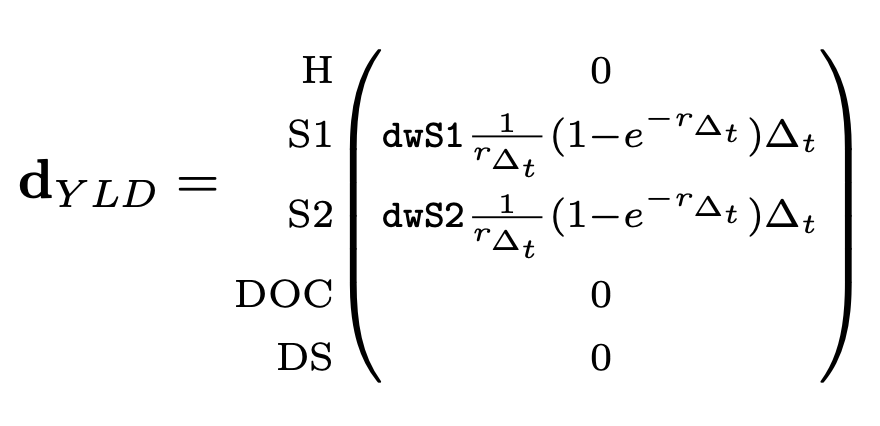

where $\texttt{dwS1}$ and $\texttt{dwS2}$ are the disability weights for the Sick and Sicker states, respectively. In addition, $r_{\Delta_t}$ is the cycle discount rate, which is calculated as,

<span id="eq-cycledisc">$$
r_{\Delta_t} = r \Delta_t
 \qquad(9)$$</span> where $r$ is the annual discount rate and $\Delta_t$ is the cycle length.

In the YLD payoff vector, the term $\frac{1}{r_{\Delta_t}}(1-e^{-r_{\Delta_t}})$ is included as a continuous-time discounting factor for the defined time step $\Delta_t$. This term is included to discount time *within* each cycle to maintain the continuous-time discounting approach used in the original GBD equations ([Larson 2013](#ref-larson2013calculating)).[2]

To fully discount outcomes, we still must discount all future outcome values back to baseline ($t=0$). Discounted years of life lost to disability (YLD) at cycle $t$ is given by

<span id="eq-yldt">$$
YLD_t=\mathbf{s}_0^{\top} \mathbf{P}_1\mathbf{P}_2\dots\mathbf{P}_t \mathbf{d}_{YLD}  \times{e^{-r_{\Delta_t} t}}
 \qquad(10)$$</span>

Total discounted YLDs are obtained by summing cycle-specific discounted YLD outcomes,

<span id="eq-yldcum">$$
YLD=\sum_{t=0}^{\omega-1} YLD_t
 \qquad(11)$$</span>

We can incorporate additional cycle adjustments (e.g., half-cycle adjustment or an adjustment based on Simpson’s rule) by defining an adjustment factor $c_t$ that multiplies the cycle-specific discounting factor (i.e., $e^{-r_{\Delta_t} t}$) with other cycle-specific adjustment values,

<span id="eq-yldcum2">$$
YLD=\sum_{t=0}^{\omega-1} YLD(t)=\sum_{t=0}^{\omega-1}\left(\mathbf{s}^{\top}_0 \mathbf{P}_1\mathbf{P}_2\dots\mathbf{P}_t \mathbf{d}_{YLD}  \times c_t \right)
 \qquad(12)$$</span> where, at a minimum, $c_t=e^{-r\Delta_t t}$ and can also include any other cycle-correction value (e.g., 0.5 for half-cycle correction or a Simpson’s rule coefficient, etc.) ([Elbasha and Chhatwal 2015](#ref-elbasha2015)).

Finally, an equivalent way to calculate YLD outcomes is through matrix multiplication of the Markov trace matrix and the YLD payoff vector,

<span id="eq-yldtrace">$$
YLD = \sum_{t=0}^{\omega-1} \mathbf{S}\mathbf{d}_{YLD} \odot \mathbf{c}
 \qquad(13)$$</span> where $\mathbf{c}$ is an $\omega \times 1$ vector of cycle discounting/correction factors $c_t$ and $\odot$ is the element-wise multiplication (Hadamard product) operator.

### 4.2.3 Years of Life Lost to Disease (YLLs): Approach 1

As noted in <a href="#sec-background" class="quarto-xref">Section 2</a> and <a href="#eq-yll" class="quarto-xref">Equation 5</a>, YLLs are based on the present value of remaining life expectancy among disease-related deaths. In a discrete time Markov model, these deaths may occur in any cycle—though, like YLDs, the fully-discounted value is calculated relative to baseline ($t=0$).

Define $a_{t}$ as the age of the cohort at cycle $t$, i.e.,

<span id="eq-aget">$$
a_t = a_0 +t \cdot \Delta_t 
 \qquad(14)$$</span> where $a_0$ is the age of the cohort at $t=0$.

We next define $Ex_t$ as the present value of remaining life expectancy of the cohort in cycle $t$.

Following the GBD discounting approach, $Ex_{t}$ is given by

<span id="eq-pvEx">$$
Ex_{t} = \frac{1}{r}\big (1 - e^{-rEx(a_{t})} \big )
 \qquad(15)$$</span>

where $Ex(a_t)$ is the remaining life expectancy at age $a$. $Ex(a_t)$ is drawn from either an exogenous (reference) life table (i.e., an external life table representing maximum length of life observed in the modern world) or an endogenous life table (i.e., a life table representing life expectancy of the modeled population), depending on the objectives of the modeling exercise ([Anand and Reddy 2019](#ref-anand2019)).

To calculate YLLs, we use the Markov trace to calculate $m_t$, the total number of new deaths from disease-related causes in each cycle. We calculate $m_t$ by taking the difference in state occupancy in the disease-related death column ($\texttt{DS}$) in adjacent cycles. As above, we can incorporate additional discounting and cycle adjustments into a cycle correction term $c_t$ and calculate total discounted (and cycle-corrected) YLLs as

<span id="eq-yllt1">$$
YLL_t=m_t Ex_t  \times{c_t} 
 \qquad(16)$$</span>

Total discounted YLLs are given by,

<span id="eq-yllcum1">$$
YLL=\sum_{t=1}^{\omega-1} YLL_t = \sum_{t=1}^{\omega-1}m_t Ex_{t}  \times{c_t} 
 \qquad(17)$$</span>

### 4.2.4 Years of Life Lost to Disease (YLLs): Approach 2

YLLs under Approach 2 can be calculated in a similar way as YLDs, since we have augmented the model with a transition tracking state that directly estimates new deaths in each cycle. Define the YLL payoff vector $\mathbf{d}_{YLL,t}$, which has value $Ex_{t}$ for the transition tracker health state ($\texttt{trDS}$) and zeros elsewhere,

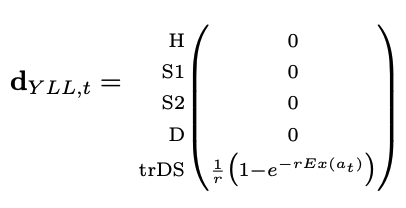

We can now apply similar equations as used for YLD outcomes to calculate fully discounted YLLs,

<span id="eq-yllcum">$$
YLL=\sum_{t=0}^{\omega-1} YLL(t)=\sum_{t=0}^{\omega-1}\left(\mathbf{s}^{\top}_0 \mathbf{P}_1\mathbf{P}_2\dots\mathbf{P}_t \mathbf{d}_{YLL,t}  \times c_t \right)
 \qquad(18)$$</span>

Alternatively, using the Markov trace, we stack each $k \times 1$ payoff vector (using $\mathbf{d}_{YLL,t}^\top$ as rows) into an $\omega \times k$ payoff matrix $\mathbf{D}$, and obtain total adjusted YLLs as

<span id="eq-ylltrace">$$
YLL = \sum_{t=0}^{\omega-1} \text{sum}(\mathbf{S} \odot \mathbf{D}) \odot \mathbf{c}
 \qquad(19)$$</span> where the $\text{sum}()$ operator sums each row across the $k$ columns that result from $\mathbf{S} \odot \mathbf{D}$.

[1] For a time-homogeneous model, <a href="#eq-trace" class="quarto-xref">Equation 7</a> simplifies to $\mathbf{s}^\top_t=\mathbf{s}^\top_0 \mathbf{P}^t$.

[2] Common discounting formulas, such as the discrete time discount factor $\frac{1}{(1+r)^t}$, as well as the continuous time discount factor $e^{-rt}$, are designed for a series of discrete “payoffs” at specific time points. By comparison, the continuous time discounting used in the GBD DALY equations (<a href="#eq-yld" class="quarto-xref">Equation 4</a> and <a href="#eq-yll" class="quarto-xref">Equation 5</a>) is based on an assumption that payoffs accrue in a continuous stream. The discount adjustment factor shown here ($\frac{1}{r}(1-e^{-rt})$)—and introduced in Larson ([2013](#ref-larson2013calculating)))—essentially “smooths out” the discrete YLD weight applied in each cycle to reflect this continuous flow. We have verified that application of this factor in our approach exactly replicate the example results using the GBD equations in Fox-Rushby and Hanson ([2001](#ref-rushby2001)); see the Supplementary Appendix for these examples and code.

In [ ]:
trace1 <- 
    with(params1, {
        m_P %>% map( ~ ({
            P = .x
            occ <- v_s0T
            P %>% map(~({
              occ <<- occ %*% .x
            })) %>% 
            map(~(data.frame(.x))) %>% 
            bind_rows()
        }))
    })  

trace2 <- 
    with(params2, {
        m_P %>% map( ~ ({
            P = .x
            occ <- v_s0T
            P %>% map(~({
              occ <<- occ %*% .x
            })) %>% 
            map(~(data.frame(.x))) %>% 
            bind_rows()
        }))
    })  

In [ ]:
# YYs
ly_ = with(params1,(matrix(c(1,
              1 ,
              1,
              0,
              0) * Delta_t,
            dimnames = list(c(
                c(v_tr_names,v_ab_names)
            ), c("UW")))
))
ly_ <- 
  with(params1,{
    v_tx_names %>% map(~({
         ly_
    }))
  }) %>% 
  set_names(params1$v_tx_names)

LYt <- 
  with(params1, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T
      d <- ly_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params1$v_tx_names)

LY = LYt %>% map(~sum(.x * gen_wcc(params1$omega, method = params1$cycle_correction))) 

# # QALYs
# qaly_ = with(params1,(matrix(c(u_H,
#               u_S1 ,
#               u_S2,
#               u_D,
#               u_D) * Delta_t,
#             dimnames = list(c(
#                 c(v_tr_names,v_ab_names)
#             ), c("UW")))
# ))
# qaly_ <- 
#   with(params1,{
#     v_tx_names %>% map(~({
#         if (.x=="A" | .x=="AB") {
#           tmp_ <- qaly_
#           tmp_[2,1] = (1 - dw_trtA) * Delta_t
#           tmp_
#       } else qaly_
#     }))
#   }) %>% 
#   set_names(params1$v_tx_names)
# 
# QALYt <-  
#   with(params1, {
#     v_tx_names %>% map( ~ ({
#       P = m_P[[.x]]
#       occ <- v_s0T
#       d <- qaly_[[.x]]
#       out <- 0
#       P %>% map(~({
#         occ <<- occ %*% .x 
#         out <<-  occ %*% d
#       })) %>% 
#         map(~(data.frame(.x))) %>% 
#         bind_rows()
#     }))
#   })  %>% 
#   set_names(params1$v_tx_names)
# 
# QALY = QALYt %>% map(~sum(.x * v_disc_h * gen_wcc(params1$omega, method = params1$cycle_correction))) 

# YLD
yld_ = with(params1,(matrix(c(0,
              dw_S1 * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t)) ,
              dw_S2 * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t)),
              0,
              0),
            dimnames = list(c(
                c(v_tr_names,v_ab_names)
            ), c("DW")))
))
yld_ <- 
  with(params1,{
    v_tx_names %>% map(~({
        if (.x=="A" | .x=="AB") {
          tmp_ <- yld_
          tmp_[2,1] = dw_trtA * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t))
          tmp_
      } else yld_
    }))
  }) %>% 
  set_names(params1$v_tx_names)

YLDt <- 
   with(params1, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T
      d <- yld_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params1$v_tx_names)
YLD = YLDt %>% map(~sum(.x*  v_disc_h[-1] * gen_wcc(params1$omega, method = params1$cycle_correction)))

# YLL
new_deaths_from_disease <- 
    map(trace1,~({
        c(0,diff(.x[,"DS"]))
    })) 

remaining_life_expectancy <- 
    with(params1,(1/r_v_disc_h) * (1 - exp(-r_v_disc_h * f_ExR(ages_trace))))
    
YLLt <- 
    new_deaths_from_disease %>% map(~(.x * remaining_life_expectancy ))

YLL <- 
    YLLt %>% map(~(sum(.x * v_disc_h * gen_wcc(params1$omega,method = params1$cycle_correction))))

DALY <- 
    map2(YLL,YLD,~(.x + .y))

# Accumulated Time in Absorbing Death State
accdaly_ = with(params1,(matrix(c(0,
              dw_S1 * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t)) ,
              dw_S2 * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t)),
              0,
              1) * Delta_t,
            dimnames = list(c(
                c(v_tr_names,v_ab_names)
            ), c("UW")))
))
accdaly_ <- 
  with(params1,{
    v_tx_names %>% map(~({
        if (.x=="A" | .x=="AB") {
          tmp_ <- accdaly_
          tmp_[2,1] = dw_trtA * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t))
          tmp_
      } else accdaly_
    }))
  }) %>% 
  set_names(params1$v_tx_names)

ACCDALYt <- 
   with(params1, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T
      d <- accdaly_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params1$v_tx_names)
ACCDALY = ACCDALYt %>% map(~sum(.x * v_disc_h * gen_wcc(params1$omega, method = params1$cycle_correction))) 

qaly_daly_ = with(params1,(matrix(c(1,
              1-dw_S1 ,
              1-dw_S2,
              0,
              0) * Delta_t,
            dimnames = list(c(
                c(v_tr_names,v_ab_names)
            ), c("QALY_DALY_")))
))
qaly_daly_ <- 
  with(params1,{
    v_tx_names %>% map(~({
        if (.x=="A" | .x=="AB") {
          tmp_ <- qaly_daly_
          tmp_[2,1] = (1-dw_trtA) * Delta_t
          tmp_
      } else qaly_daly_
    }))
  }) %>% 
  set_names(params1$v_tx_names)

QALY_DALYt <-    
  with(params1, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T
      d <- qaly_daly_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params1$v_tx_names)

QALY_DALY = QALY_DALYt %>% map(~sum(.x * v_disc_h * gen_wcc(params1$omega, method = params1$cycle_correction))) 

# Costs
cost_ = with(params1,(matrix(c(c_H,
              c_S1 ,
              c_S2,
              c_D,
              c_D)*Delta_t,
            dimnames = list(c(
                c(v_tr_names,v_ab_names)
            ), c("COST")))
))
cost_ <-
  with(params1, {
    v_tx_names %>% map( ~ ({
      if (.x == "A") {
        tmp_ <- cost_
        tmp_["S1", 1] = (c_S1 + c_trtA)*Delta_t
        tmp_["S2", 1] = (c_S2 + c_trtA)*Delta_t
        tmp_
      } else if (.x == "B") {
        tmp_ <- cost_
        tmp_["S1", 1] = (c_S1 + c_trtB)*Delta_t
        tmp_["S2", 1] = (c_S2 + c_trtB)*Delta_t
        tmp_
      } else if (.x == "AB") {
        tmp_ <- cost_
        tmp_["S1", 1] = (c_S1 + c_trtA + c_trtB)*Delta_t
        tmp_["S2", 1] = (c_S2 + c_trtA + c_trtB)*Delta_t
        tmp_
      } else cost_
    }))
  }) %>% 
  set_names(params1$v_tx_names)

COSTt <- 
  with(params1, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T
      d <- cost_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params1$v_tx_names)

COST = COSTt %>% map(~sum(.x * v_disc_c * gen_wcc(params1$omega, method = params1$cycle_correction))) 

result1 <- cbind(LY, YLD, YLL, DALY, ACCDALY, QALY_DALY, COST) %>%
  as.data.frame() %>%
  mutate_all( ~ as.numeric(.))  %>%
  rownames_to_column(var = "strategy") %>%
  mutate(approach = "Markov Trace") %>% 
  dplyr::select(approach, strategy, everything()) 

### 4.2.5 DALY Shortcut Methods

We also consider two shortcut methods for estimating DALYs. First, we execute a method that defines cycle payoffs based on the disability weight for the diseased health states, and assigns a payoff value of 1.0 for cycles in the disease-related death state. Thus, this method accumulates time in the death state as an estimate of YLLs. This is the method included in the TreeAge Pro software package as a template/example for calculating DALY outcomes.[1]

Second, we consider a simpler **QALY-like-DALY** method. This approach defines the cycle occupancy payoff for the sick and sicker states as one minus the disability weight. As is common practice, under this method the healthy state receives a payoff value of 1.0, while the death state receives a value of 0.0.

# 5. Results

## 5.1 Comparison of DALY Outcomes Under All Three Approaches

<a href="#tbl-compare1" class="quarto-xref">Table 2</a> draws on the Sick-Sicker model parameters and shows YLD, YLL and DALY outcomes estimates. Note that because Approaches 1 and 2 yield identical values, we only present one set of estimates in the table.

[1] TreeAge example model can be found in `Example Models/Healthcare/Markov Cancer Decision - DALY.trex`.

In [ ]:
tab <- 
  result1 %>% 
  select(approach,strategy,YLD,YLL,DALY) %>% 
  gather(outcome,value,-strategy,-approach) %>% 
  mutate(approach = case_when(
    approach == "Markov Trace" ~ "1-2",
    .default = "3"
  )) %>% 
  unite(outcome,outcome,approach) %>% 
  pivot_wider(names_from = outcome, values_from = value) %>% 
  mutate(strategy = case_when(
    strategy ==  "SoC" ~ "Standard of Care",
    strategy == "A" ~ "Strategy A: Quality of Life Improvement",
    strategy == "B" ~ "Strategy B: Reduce Disease Progression",
    strategy == "AB" ~ "Composite: Strategy A + Strategy B"
  ))  %>% 
  janitor::clean_names()   %>% 
  mutate_at(vars(-strategy), function(x) format_number(x)) 

tab %>% flextable( 
  col_keys = c("strategy","blah","yld_1_2","foo","yll_1_2","foo2","daly_1_2")) %>% 
  delete_part("header")  %>% 
  add_header_row( values = c("Strategy","","Years Living With Disease (YLDs)","","Years of Life Lost to Premature Mortality (YLLs)","","Disability-Adjusted Life Years (DALYs)"),colwidths = c(1,1,1,1,1,1,1)) %>% 
  align(part="header",align="right") %>% 
  align(part = "body", align = "right") %>% 
  width(j = 1, width=2) %>% 
  width(j=2:7,width=.75) %>% 
  flextable::theme_vanilla() %>% 
  empty_blanks()

## 5.2 Comparison with “Shortcut-based” DALY Approaches

<a href="#tbl-cea" class="quarto-xref">Table 3</a> reports cost, effect and incremental cost-effectiveness ratio (ICER) results for our two DALY approaches. The table also includes results under two “shortcut” DALY strategies.

In [ ]:
cea <- 
  bind_rows(
    dampack::calculate_icers(cost = result1$COST, effect = -result1$DALY, strategies = result1$strategy) %>% 
      mutate(Effect = -Effect) %>% mutate(approach = "1 & 2")
  ) %>% 
  bind_rows(
    dampack::calculate_icers(cost = result1$COST, effect = -result1$ACCDALY, strategies = result1$strategy) %>% 
            mutate(Effect = -Effect) %>% mutate(approach = "AccDALY")
    
  ) %>%   
  bind_rows(
    dampack::calculate_icers(cost = result1$COST, effect = result1$QALY_DALY, strategies = result1$strategy) %>% 
      mutate(approach = "QALY-like-DALY")
  )  %>% 
  mutate_at(vars(ICER,Inc_Cost,Cost), ~case_when(Status=="ND" & is.na(.)~"ref.", 
                                                  Status=="D" & is.na(.) ~ "D", 
                                                  .default=as.character(prettyNum(round(.,0), big.mark=",")))) %>% 
  mutate_at(vars(Inc_Effect,Effect), ~case_when(Status=="ND" & is.na(.)~"ref.", 
                                                  Status=="D"& is.na(.) ~ "D" , 
                                                  .default=as.character(prettyNum(round(.,3), big.mark=","))))  %>% 
  select(approach,Strategy,Cost,Inc_Cost,Effect,Inc_Effect,ICER) %>% 
  mutate_at(vars(Inc_Effect,ICER),function(x) case_when(x=="D" ~ "Dominated",
                                                        TRUE ~ x))

cea %>% 
  mutate_at(vars(Cost,Inc_Cost,ICER), function(x) ifelse(grepl("^[0-9]",x), paste0("$",x),x)) %>% 
  gather(outcome,value,-approach,-Strategy) %>% 
  unite(outcome,outcome,approach) %>% 
  pivot_wider(names_from = outcome, values_from = value) %>% 
  janitor::clean_names() %>% 
  select(strategy,contains("1_2"), contains("acc_daly"), contains("qaly_like")) %>% 
  gather(outcome_,value,-strategy) %>% 
  mutate(outcome = case_when(
    grepl("^cost_",outcome_) ~ "Cost",
    grepl("^inc_cost",outcome_) ~ "inc_cost",
    grepl("^inc_effect",outcome_) ~ "inc_effect",
    grepl("^effect",outcome_) ~ "DALY",
    grepl("icer",outcome_) ~ "ICER")
  ) %>% 
  mutate(approach = case_when(
    grepl("_1_2",outcome_) ~ "1_2",
    grepl("acc_daly",outcome_)~ "accDALY",
    grepl("qaly_like_daly",outcome_) ~ "QALYDALY"
  )) %>% 
  mutate(strategy = case_when(
    strategy ==  "SoC" ~ "Standard of Care",
    strategy == "A" ~ "Strategy A: Quality of Life Improvement",
    strategy == "B" ~ "Strategy B: Reduce Disease Progression",
    strategy == "AB" ~ "Composite: Strategy A + Strategy B"
  )) %>% 
  select(-outcome_) %>% 
  spread(approach,value) %>% 
  mutate(strategy = factor(strategy,levels = c("Standard of Care","Strategy B: Reduce Disease Progression","Composite: Strategy A + Strategy B","Strategy A: Quality of Life Improvement"))) %>% 
  filter(outcome %in% c("Cost","DALY","ICER")) %>% 
  mutate(outcome = factor(outcome,levels = c("Cost","DALY","ICER"))) %>% 
  arrange(outcome,strategy) %>% 
  as_grouped_data(groups = "outcome", columns = NULL) %>% 
  as_flextable(hide_grouplabel = TRUE,
               col_keys = c("strategy","blah","1_2","foo","accDALY","foo2","QALYDALY") )  %>% 
  set_header_labels(
    strategy = "",
    "1_2" = "Approaches 1 & 2",
    "accDALY" = "Shortcut 1: Accumulate Death State Occupancy",
    "QALYDALY" = "Shortcut 2: QALY-like DALY"
  ) %>% 
  align(part="header",align="left") %>% 
  width(j = 1, width=2) %>% 
  width(j=2:7,width=1) %>% 
  empty_blanks()

<a href="#tbl-cea" class="quarto-xref">Table 3</a> also includes outcomes under alternative “shortcut”-based DALY estimation approaches. The death state occupancy method yields DALY estimates that are 34% higher than our approaches, and results in an ICER that is 25% lower for Strategy B vs. the standard of care. The ICER for strategy AB is calculated relative to strategy B, so the only difference is additional improvement in quality life from strategy A. This improvement works exclusively through the YLD channel, as there is no differential effect on mortality. With this key information in mind, we note that the ICER for AB vs. B is more similar between our approaches and the death state occupancy method.

QALY-like DALY estimates are, not surprisingly, higher than the other DALY estimates, owing to their conceptual difference with DALYs (i.e., QALYs accumulate and reward the quality and extension of life, while DALYs accumulate years lost to disease). Again, ICERs for strategy A vs. the standard of care are about 25% lower, while they are very similar to our DALY approaches for the AB strategy that differentially improves quality of life.

# 6. Discussion

This study extends the methodological toolkit available to decision modelers by introducing two DALY estimation methods. Our approaches are designed to fit a spectrum of experience and skill—thus making our methods accessible to any practitioner who aims to include DALYs in their decision model. Our results demonstrate that both beginner and intermediate approaches yield similar values for DALY levels and incremental cost-effectiveness ratios in a progressive disease model constructed for didactic purposes. Finally, we also show that other shortcuts suggested for DALY outcomes do not in general yield similar results for either DALY levels or ICERs.

Our methods also extend to other common decision modeling frameworks. For example, Approach 2 directly estimates YLDs and YLLs in each cycle—and can therefore be adapted to efficiently execute microsimulation models in which cycle transition probabilities depend on patient attributes or disease history. Discrete event simulation models, moreover, can apply the YLD and YLL equations provided (<a href="#eq-yll" class="quarto-xref">Equation 5</a> and <a href="#eq-yld" class="quarto-xref">Equation 4</a>) to simulated time-to-death and duration of disease values.

A subset of our results yielded similar values when comparing DALY shortcuts to our DALY approaches, so it is useful to walk through the circumstances when various approaches will be similar and differ. In general, DALY shortcut methods will be more accurate when YLDs dominate the DALY value. The reason is that our methods, as well as standard (“QALY-like”) methods, apply identical payoff weights to occupancy in diseased states. The methods differ substantially, however, in how they “reward” deaths from disease. Our methods mirror the GBD approach of penalizing a disease-related death using an exogenous remaining life expectancy value. Shortcut-based methods, by comparison, accumulate time in the disease-related death state—thus, the payoffs are determined endogenously within the model. Moreover, because a payoff value is applied to an absorbing state, results under the shortcut-based DALY method will be highly sensitive to the time horizon in a model. That is, “YLLs” will continue to accumulate even after all cohort members have died. This will not greatly impact ICER calculations that make comparisons *across* strategies but will yield inaccurate DALY levels in a modeled population.

Another important consideration is the role of discounting. Our approaches apply continuous-time discounting approach to maintain consistency with the GBD assumption that remaining life expectancy accrues as a continuous “flow” of health. This manifests in our approaches through the use of a cycle-specific discount factor ($\frac{1}{r_{\Delta_t}}(1-e^{-r_{\Delta_t}})$) and a continuous-time formula $e^{-rt}$ to discount values to baseline. If practitioners do not wish to discount, the discount rate value can simply be set to zero.[1] Alternatively, practitioners may also elect to use the standard discrete time discounting formula ($\frac{1}{(1+r^*)^t}$), but can first convert the discount rate as $r^*=e^{r}-1$.

Finally, it is important to note that the methods outlined here are not purely restricted to DALY outcomes. Indeed, each approach facilitates the estimation of other common outcomes such as QALYs, life-years, etc.

# References

Alarid-Escudero, Fernando, Eline Krijkamp, Eva A Enns, Alan Yang, MG Myriam Hunink, Petros Pechlivanoglou, and Hawre Jalal. 2023. “An Introductory Tutorial on Cohort State-Transition Models in r Using a Cost-Effectiveness Analysis Example.” *Medical Decision Making* 43 (1): 3–20.

Anand, Sudhir, and Sanjay G. Reddy. 2019. “The Construction of the DALY: Implications and Anomalies.” *SSRN Electronic Journal*. <https://doi.org/10.2139/ssrn.3451311>.

Arnesen, T., and E. Nord. 1999. “The Value of DALY Life: Problems with Ethics and Validity of Disability Adjusted Life Years.” *BMJ* 319 (7222): 1423–25. <https://doi.org/10.1136/bmj.319.7222.1423>.

Bertram, Melanie Y., Jeremy A. Lauer, Karin Stenberg, and Tessa Tan Torres Edejer. 2021. “Methods for the Economic Evaluation of Health Care Interventions for Priority Setting in the Health System: An Update From WHO CHOICE.” *International Journal of Health Policy and Management*, January. <https://doi.org/10.34172/ijhpm.2020.244>.

Disease Collaborative Network, Global Burden of. 2021. “Global Burden of Disease Study 2019 (GBD 2019) Reference Life Table.” Institute for Health Metrics; Evaluation (IHME). <https://doi.org/10.6069/1D4Y-YQ37>.

———. 2024. “Global Burden of Disease Study 2021 Disability Weights.” *Global Burden of Disease Study*. <https://ghdx.healthdata.org/record/ihme-data/gbd-2021-disability-weights#:~:text=Disability%20weights%2C%20which%20represent%20the,health%20and%201%20equals%20death>.

Elbasha, Elamin H., and Jagpreet Chhatwal. 2015. “Theoretical Foundations and Practical Applications of Within-Cycle Correction Methods.” *Medical Decision Making* 36 (1): 115–31. <https://doi.org/10.1177/0272989x15585121>.

Feng, Xue, David D. Kim, Joshua T. Cohen, Peter J. Neumann, and Daniel A. Ollendorf. 2020. “Using QALYs Versus DALYs to Measure Cost-Effectiveness: How Much Does It Matter?” *International Journal of Technology Assessment in Health Care* 36 (2): 96–103. <https://doi.org/10.1017/s0266462320000124>.

Fox-Rushby, Ja, and K Hanson. 2001. “Calculating and Presenting Disability Adjusted Life Years (DALYs) in Cost-Effectiveness Analysis.” *Health Policy and Planning* 16 (3): 326–31. <https://doi.org/10.1093/heapol/16.3.326>.

Graves, John, Shawn Garbett, Zilu Zhou, Jonathan S. Schildcrout, and Josh Peterson. 2021. “Comparison of Decision Modeling Approaches for Health Technology and Policy Evaluation.” *Medical Decision Making* 41 (4): 453–64. <https://doi.org/10.1177/0272989x21995805>.

Iosifescu, M. 1980. “Finite Markov Processes and Their Applications. Wiley.” *New York*.

Larson, Bruce A. 2013. “Calculating Disability-Adjusted-Life-Years Lost (DALYs) in Discrete-Time.” *Cost Effectiveness and Resource Allocation* 11 (1): 1–6.

Mathers, Colin D. 2020. “History of Global Burden of Disease Assessment at the World Health Organization.” *Archives of Public Health* 78 (1). <https://doi.org/10.1186/s13690-020-00458-3>.

Murray, Christopher J L, Aleksandr Y Aravkin, Peng Zheng, Cristiana Abbafati, Kaja M Abbas, Mohsen Abbasi-Kangevari, Foad Abd-Allah, et al. 2020. “Global Burden of 87 Risk Factors in 204 Countries and Territories, 19902019: A Systematic Analysis for the Global Burden of Disease Study 2019.” *The Lancet* 396 (10258): 1223–49. <https://doi.org/10.1016/s0140-6736(20)30752-2>.

Murray, Christopher JL, and Alan D Lopez. 1997. “Mortality by Cause for Eight Regions of the World: Global Burden of Disease Study.” *The Lancet* 349 (9061): 1269–76. <https://doi.org/10.1016/s0140-6736(96)07493-4>.

Parks, Rachel. 2014. “The Rise, Critique and Persistence of the DALY in Global Health.” *The Journal of Global Health at Columbia University*, April, Vol. 4 No. 1 (2014): Spring 2014. <https://doi.org/10.7916/THEJGH.V4I1.4893>.

WHO, Geneva. 2020. “WHO Methods and Data Sources for Global Burden of Disease Estimates 2000–2019.” *Geneva: Department of Health Statistics and Information Systems*. <https://cdn.who.int/media/docs/default-source/gho-documents/global-health-estimates/ghe2019_daly-methods.pdf>.

Wilkinson, Thomas, Mark J. Sculpher, Karl Claxton, Paul Revill, Andrew Briggs, John A. Cairns, Yot Teerawattananon, et al. 2016. “The International Decision Support Initiative Reference Case for Economic Evaluation: An Aid to Thought.” *Value in Health* 19 (8): 921–28. <https://doi.org/10.1016/j.jval.2016.04.015>.

[1] Our R code cannot accommodate a discout rate of precisely zero; instead, a value such as 1e-6 can be used.